# Individual heat maps based on Open Street Map data to identify locations in a data-driven way

## Introduction 

If have had the challenge to find locations in a data-driven way. Therefore I wanted to create an individual heat map that visualizes data densities. Common heat maps visualize a density of underlying data. High density is displayed as red, low density as green with a colour scheme operating in the background. This article is about how to create individual heat maps to identify locations in a data-driven manner. This saves time and focusses on the important parts of acquiring a new location.

Let's start out with a problem statement. Say you are looking for a nice place to live which you can afford, say you are a company looking for your next warehouse or you are trying to find the right spot for your new office. In every case there are several approaches on how to search. In this article I am presenting a simple approach to gather data from Open Street Map and find a function to carry out a heat map to focus on the spots where to search.

A location here is basically a building or a spot on earth where one of the above conditions suffice. For a location there could be a lot of data-driven factors which determine the quality and conditions, for example, weather, infrastructure, socio-economic factors, local expertise, building status and whatever you can think of. In case of a nice place to live you would probably want to be close to parks, bars, health infrastructure,  shops or schools. In case of a new warehouse you would want to be close to transport infrastructure like railways or highways, probably in a more industrial grown area. A new office location might be in city centres where there is enough space for your employees, suitable food capabilities, transportation infrastructure and, of course, electricity for your coffee machine.

After receiving data from Open Street Map (OSM) we create a map to visualize data with folium package. Finding that there are a lot of entities in this geographical data we want to aggregate this data into a grid. Every point of this grid could be a starting point to search for a location so we create a function that accounts for the above parameters. This individual function then maps to a color map to create a heat map out of these grid points.

Let's start with gathering data from OSM.

## Gather data from OSM

Before we start, we import overpy and, as a standard, pandas and numpy. Folium is to represent the nodes on a corresponding map.

In [ ]:
#!pip install nb_black
#%pip install overpy

%load_ext lab_black

In [ ]:
import overpy  # gather data from OSM

import pandas as pd
import numpy as np

import folium as fl

There are several ways to gather data from OSM. Here, we use overpy API. General idea is to pass a query to overpass which returns data in a specific format. OSM works like having nodes, ways consisting of nodes and relations between these entities. It is easy to try these queries on overpass turbo webpage, see https://overpass-turbo.eu/. Here we extract nodes in a specific bounding box of type amenity where the description is 'school'. The function written here then can be used to query several types of amenities. Let's start with an example by specifying a bounding box and a starting point, here it is Düsseldorf in Germany. 

In [ ]:
start_point = (51.2195, 6.79211)  # Düsseldorf

boundbox = (51.136553, 6.669070, 51.311082, 6.921142)  # Düsseldorf


def get_amenity_nodes(amenity_str, bbox):
    ###
    api = overpy.Overpass()
    a, b, c, d = bbox[0], bbox[1], bbox[2], bbox[3]
    long_str = (
        '[out:json][timeout:25];(node["amenity"= "'
        + amenity_str
        + '"](%s,%s,%s,%s););out body;>;out skel qt;' % (a, b, c, d)
    )
    result = api.query(long_str)
    dict_out = dict()
    # cycling through result to simply extrat geographical information
    for item in result.nodes:
        dict_out[item.id] = (float(item.lat), float(item.lon))
    return dict_out


res_edu = get_amenity_nodes("school", boundbox)

For a quick look at a map we introduce m as a folium map with a specific starting point in the middle of the bounding box. Cycling through the dictionary and saving each point as a Circle Marker we find the following:
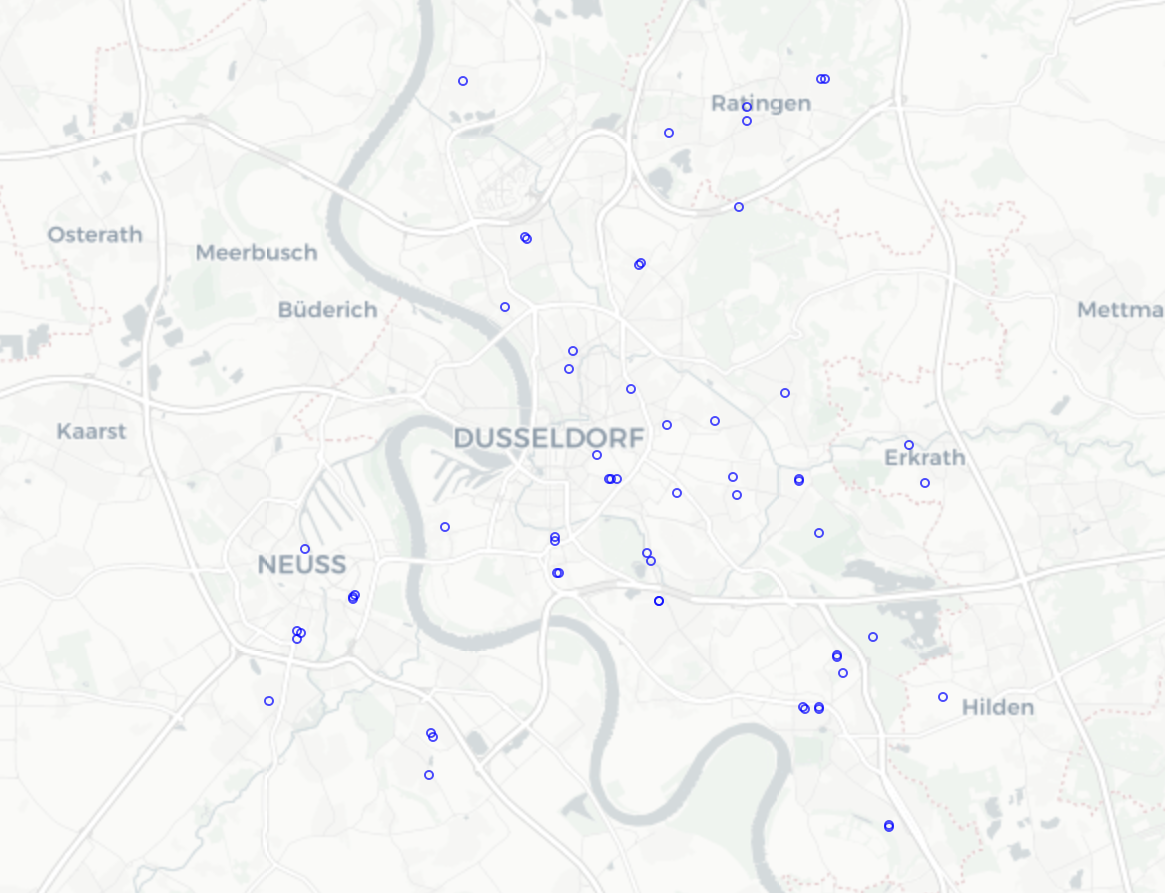

In [ ]:
m = fl.Map(location=list(start_point), zoom_start=11, tiles="cartodbpositron")

fg = fl.FeatureGroup("Schools in Düsseldorf", show=True)

for key in res_edu:
    fl.CircleMarker(
        location=[res_edu[key][0], res_edu[key][1]],
        radius=2,
        color="blue",
        weight=1,
        opacity=0.7,
    ).add_to(fg)

fg.add_to(m)

fl.LayerControl().add_to(m)

m

With these tools at hand we are able to go a bit further. For example for the amenity node there are several tags that could describe education like school, kindergarten or university. On the other hand we improve the function from above by passing an argument to specify if it should be amenity or some other tag. This generalizes a bit, so we can also identify shops or something else we could think of.

So, in just a few lines there is data from OSM about education, bars, public transportation, health infrastructure and shops.

In [ ]:
def get_nodes(list_in, bbox, tag_name):
    ###
    api = overpy.Overpass()
    a, b, c, d = bbox[0], bbox[1], bbox[2], bbox[3]
    dict_out = dict()
    try:
        for item in list_in:
            long_str = (
                '[out:json][timeout:25];(node["'
                + tag_name
                + '" = "'
                + item
                + '"](%s,%s,%s,%s););out body;>;out skel qt;' % (a, b, c, d)
            )
            result = api.query(long_str)
            for item in result.nodes:
                dict_out[item.id] = (float(item.lat), float(item.lon))
    except:
        pass
    return dict_out


res_edu = get_nodes(["school", "kindergarten", "university"], boundbox, "amenity",)
res_bars = get_nodes(["bar"], boundbox, "amenity",)
res_transport = get_nodes(["bus_station", "car_sharing", "taxi"], boundbox, "amenity",)
res_health = get_nodes(["dentist", "hospital", "pharmacy"], boundbox, "amenity",)
res_supermarket = get_nodes(["supermarket"], boundbox, "shop",)

Great! To visualize these nodes we incorporate another function that outputs FeatureGroups by passing the dictionaries, color, radiants and opacity. 

In [ ]:
def create_osm_node_layer(output_str, out_col, out_dict, out_rad, out_weight, opac):
    fg = fl.FeatureGroup(name=output_str, show=True)  # create layer

    for key in out_dict:
        fl.CircleMarker(
            location=[out_dict[key][0], out_dict[key][1]],
            radius=out_rad,
            color=out_col,
            weight=out_weight,
            opacity=opac,
        ).add_to(fg)
    return fg


m = fl.Map(location=list(start_point), zoom_start=11, tiles="cartodbpositron")

create_osm_node_layer("Bildung", "dodgerblue", res_edu, 3, 2, 0.7).add_to(m)

create_osm_node_layer("Bars", "cadetblue", res_bars, 3, 2, 0.7).add_to(m)

create_osm_node_layer("Transportation", "gold", res_transport, 3, 2, 0.7).add_to(m)

create_osm_node_layer(
    "Krankenversorgung", "mediumseagreen", res_health, 3, 2, 0.7
).add_to(m)

create_osm_node_layer("Shop", "deepskyblue", res_supermarket, 3, 2, 0.7).add_to(m)

fl.LayerControl().add_to(m)

m

Now the output map looks quite messy, see picture below. In the next section we are going to fix this by implementing a grid. With this grid we can then implement a function to locally weights every point of the grid depending on its neighbourhood which then leads to an individual heat map.

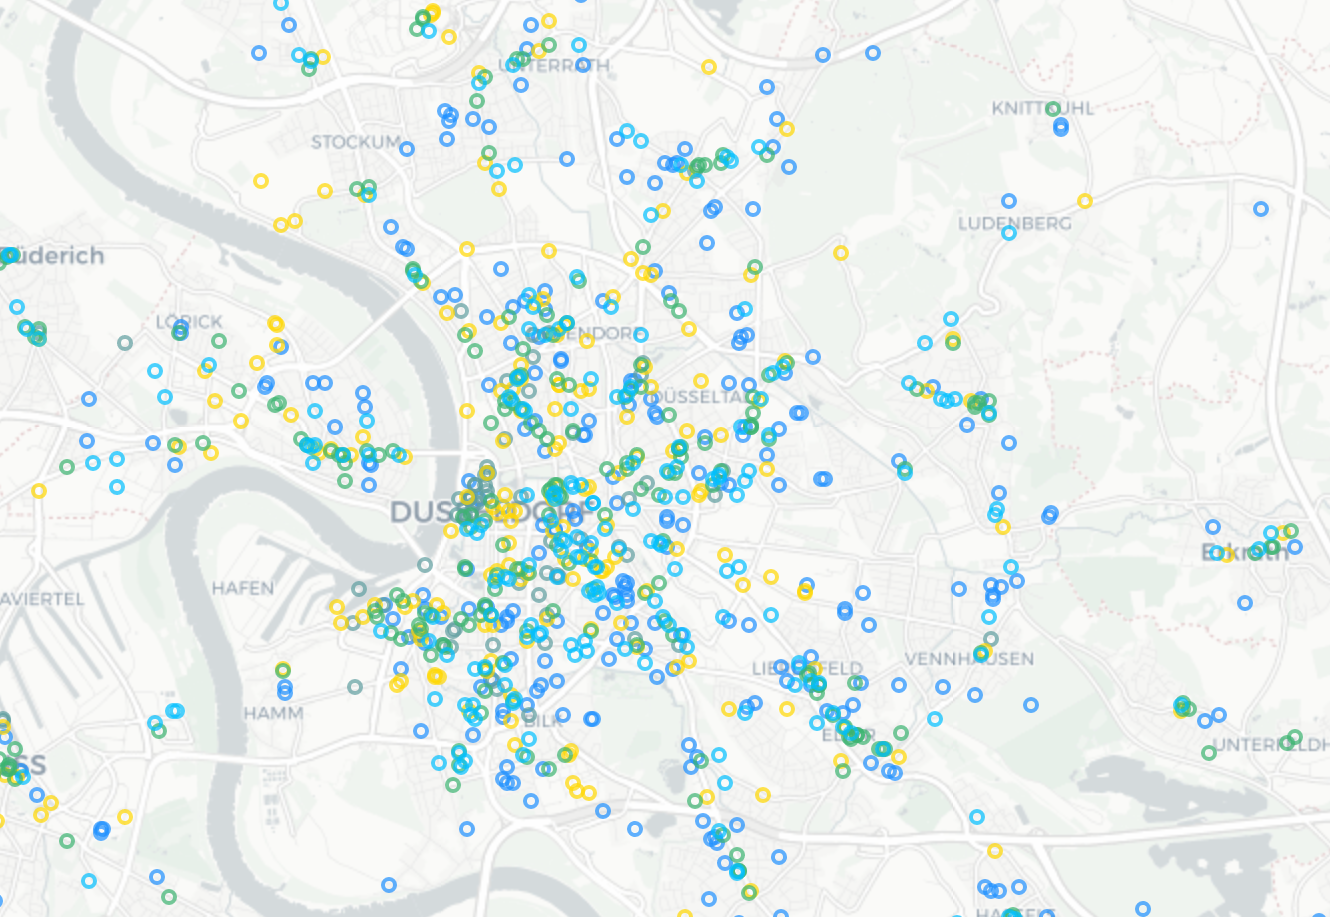

## Implementing a grid algorithm

The strategy to implement a heat map is as follows. Starting off with a quadratic grid, there will be functions to transform between geographical projections. ....

Commenting geographical projections: At this point there was just one basic coordinate reference system (crs) that has been used here, i.e.  WGS84 - based on latitude and longitude degrees referring to specific points on earth. In this coordinate system it is quite difficult to measure distances without transformation into planar coordinates. Python has a specific package to do this transformation, namely pyproj. So, if you know which is the source projection and the target projection you are able to transform.

So, we start by implementing a grid according to the given bounding box. The size of the grid is determined by the parameter grid_depth. Be aware of this parameter, it is behaving in quadratical order, growing fast, consuming compute power. This code is not really optimized for fast computations so handle with care.

In [ ]:
from pyproj import Transformer

import math  # Import package for euclidian distance


def return_transformed_geo_coords(list_coords_in, crs_in=4326, crs_out=25832) -> list:
    ### A function transforming coordinates from an input list to an output list
    ### regarding specific coordinate reference systems
    transformer = Transformer.from_crs(crs_in, crs_out)
    return [transformer.transform(i[0], i[1]) for i in list_coords_in]


bbox_wgs = return_transformed_geo_coords(
    [(boundbox[0], boundbox[1]), (boundbox[2], boundbox[3])]
)

x_min = bbox_wgs[0][0]
x_max = bbox_wgs[1][0]
y_min = bbox_wgs[0][1]
y_max = bbox_wgs[1][1]

grid_depth = 100j  # as a complex number
X, Y = np.mgrid[x_min:x_max:grid_depth, y_min:y_max:grid_depth]
xy = np.vstack((X.flatten(), Y.flatten())).T

To see if this has happened correctly, there will be an output dictionary called dict_targets where we are retransforming the grid to see if this has worked fine. The picture below shows what the output will look like if this would be put on a map.

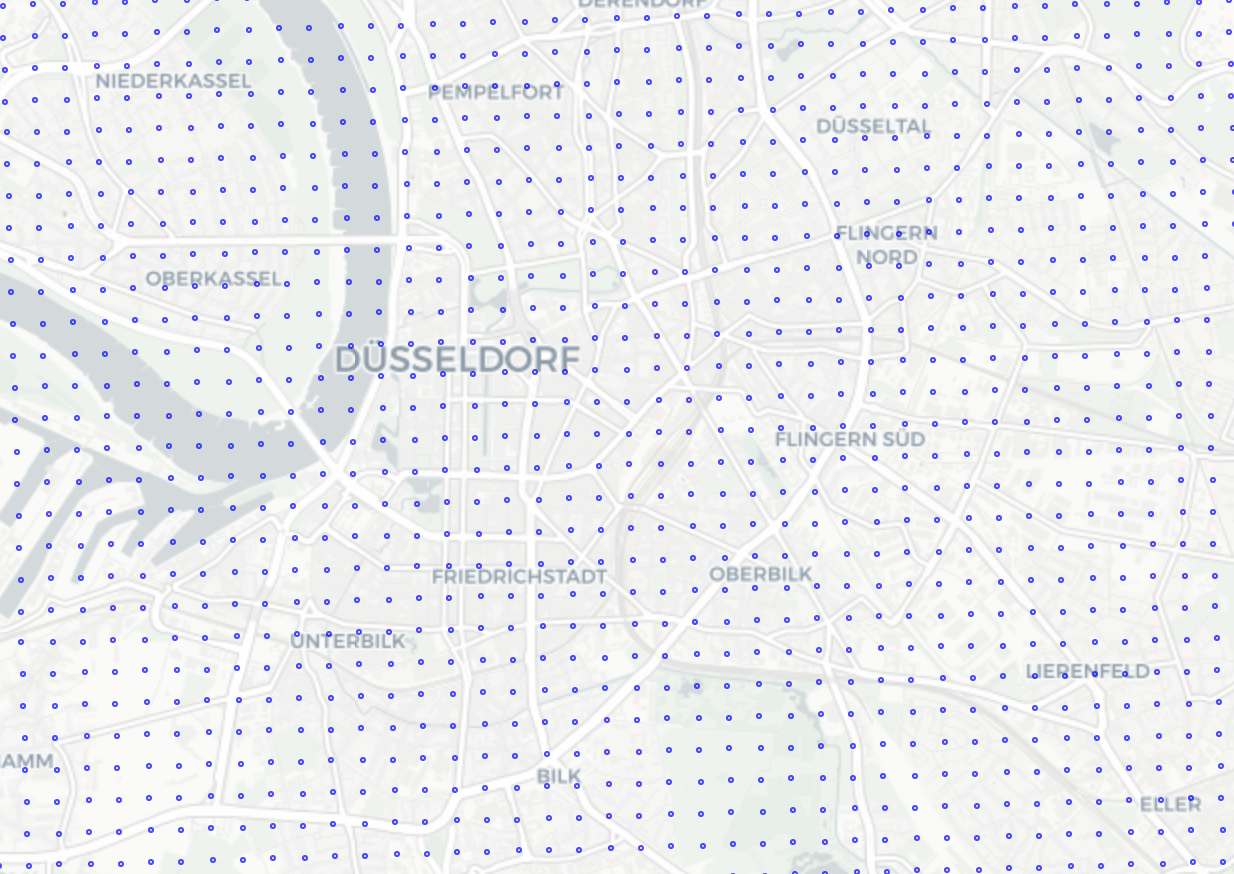

In [ ]:
from shapely.geometry import Point

## Creating dictionary for output values
dict_targets = dict()

for i in range(0, len(xy)):
    in_list = [list(xy[i])]
    local_answer = return_transformed_geo_coords(in_list, 25832, 4326)
    dict_targets[i] = [in_list[0], local_answer[0], Point(local_answer)]


m2 = fl.Map(location=list(start_point), zoom_start=11, tiles="cartodbpositron")

fg = fl.FeatureGroup("grid", show=True)
for key in dict_targets:
    fl.CircleMarker(
        location=[dict_targets[key][1][0], dict_targets[key][1][1]],
        radius=1,
        color="blue",
        weight=1,
        opacity=0.7,
    ).add_to(fg)

fg.add_to(m2)

fl.LayerControl().add_to(m2)
m2

So, by now we have transformed the corresponding grid in both coordinate reference systems. Proceeding with a coordinate transformation for our input we find the following code snippet. The transformation will be stored in corresponding dictionaries.

In [ ]:
def transform_dict_coords(dict_in):
    return {
        k: return_transformed_geo_coords([[list(v)[0], list(v)[1]]])[0]
        for k, v in dict_in.items()
    }


res_edu_gk = transform_dict_coords(res_edu)
res_bars_gk = transform_dict_coords(res_bars)
res_trans_gk = transform_dict_coords(res_transport)
res_health_gk = transform_dict_coords(res_health)
res_supermarket_gk = transform_dict_coords(res_supermarket)

The strategy in the next step is the following: For every point of the grid we define a search radius given in meter. Is there any bar inside this search radius, add the index of the nearest bar in the search radius to the grid point, if not, leave it empty.

To implement a function that suffices this condition we pass the grid point, the dictionary of points we are searching for, the dictionary of corresponding wgs 84 points to directly return the correct coordinates for mappping, an adequate output name for a layer and a search readius. This function creates a buffer or circle with the given grid point as center and radius defined by search radius. For every point in the given dictionary we check if it lays within this buffer or not. If this is the case then calculate the euclidian distance and store in the given internal dictionary. If there is a minimal point in this search radius return the key of the dictionary and the corresponding coordinates.

Cycling through all given input dictionaries takes some time but afterwards we find a nice output identifying bars, supermarkets, etc. for every grid point.

In [ ]:
search_radius = 1000  # measured by meter


def get_next_point(point_in, dict_in_gk, dict_in, str_layer, search_rad=search_radius):
    dict_intern = dict()  # creating an internal dictionary for data storage
    buffer_obj = Point(point_in).buffer(
        search_rad
    )  # creating a buffer around the given grid point
    # cycle through dictionary
    for key in dict_in_gk:
        # add point and calculate euclidian distance to internal dictionary
        if Point(dict_in_gk[key]).within(buffer_obj):
            dict_intern[key] = math.dist(dict_in_gk[key], point_in)
    # if there is a minimal point, return that, else return None
    try:
        min_key = min(dict_intern, key=dict_intern.get)
        return [min_key, dict_intern[min_key], dict_in[min_key]]
    except:
        return


def fill_dict_targets_locally(layer_name, dict_target_in, dict_search_gk, dict_search):
    for key in dict_target_in:
        try:
            dict_target_in[key] = dict_target_in[key] + [
                {
                    layer_name: get_next_point(
                        dict_target_in[key][0], dict_search_gk, dict_search, layer_name
                    )
                }
            ]
        except:
            pass
    return dict_target_in

So, we cycle through every of the above entities finally arriving at an output dictionary that incorporates all nearest entities for every grid point.

In [ ]:
dict_targets = fill_dict_targets_locally("Bars", dict_targets, res_bars_gk, res_bars)

dict_targets = fill_dict_targets_locally("Edu", dict_targets, res_edu_gk, res_edu)

dict_targets = fill_dict_targets_locally(
    "Transport", dict_targets, res_trans_gk, res_transport
)
dict_targets = fill_dict_targets_locally(
    "Health", dict_targets, res_health_gk, res_health
)
dict_targets = fill_dict_targets_locally(
    "Supermarket", dict_targets, res_supermarket_gk, res_supermarket
)

An example could be to take a look a node number 135, i.e.
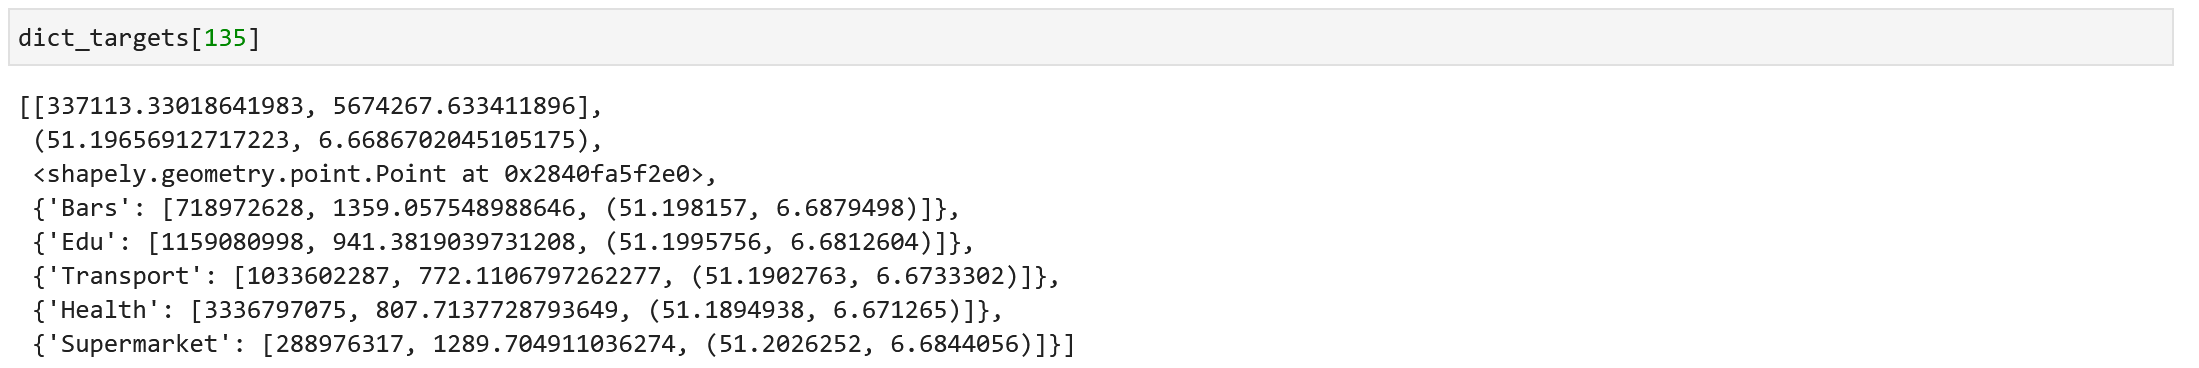

having a entities filled with nearest points.

## A color key for resulting nodes

Having these results in mind, there now might be several ways to choose an adequate color for every node. One way could be to calculate an easy score value for every node. If a bar is in the buffer, add 1, if a school is around the block add 1, and so on. This gives you a highest score of 5 and lowest of 0. Map colors from green to red and thereby a heat map results. Making it a little more difficult we weight every entity which can be present or not by a preference factor that adds up to one, i.e. for every entity $e_i \in \{0,1\}$ for $i \in \{0,\ldots,n\}$ with $n \in \mathrm{N}$ we say that
$$ \sum_{i=1}^n \alpha_i \cdot e_i \textrm{ , where} \quad \sum_{i=1}^n \alpha_i = 1$$
holds. In our case $n = 5$ and a preference dictionary could look like this where the keys for sure have to fit the keys from dict_targets.

In [ ]:
dict_pref = {
    "Bars": 0.3,
    "Edu": 0.1,
    "Transport": 0.1,
    "Health": 0.2,
    "Supermarket": 0.3,
}

The next code snippet calculates this score for every grid point and adds it to dict_targets, i.e.

In [ ]:
def calculate_score(dict_entry, dict_pref, liste_keys):
    score = 0
    num_int = 3
    for keys in liste_keys:
        if dict_entry[num_int][keys] != None:
            score += dict_pref[keys]
        num_int += 1
    return score


liste_keys = ["Bars", "Edu", "Transport", "Health", "Supermarket"]

for key in dict_targets:
    dict_targets[key] = dict_targets[key] + [
        calculate_score(dict_targets[key], dict_pref, liste_keys)
    ]

When you search for colormaps it is almost always about matplotlib and how to switch from one colormap to another in scatterplots or other plot categories. So, I've had to tackle the problem myself. I would like to define a starting and ending color that ranges over n different colors, linearly spread. The colors are specified in a red-green-blue scheme ranging from 0 to 255, i.e. start_col and end_col, here from red to yellow over 10 steps. Before we turn the scores into colors we create auxiliary dictionaries, i.e. col_steps and int_steps. For every step they hold a color in hexadecimal string-format and the specific steps between 0 and 1 to model the corresponding intervals. Whenever a score-value is lower than a current value of the int_steps dictionary, then the loop breaks and the corresponding color will be returned. That's it. 

In [ ]:
num_col_scale = 10

start_col = [255, 0, 0]  # red
end_col = [255, 255, 0]  # yellow

diff_step = [(end_col[i] - start_col[i]) / num_col_scale for i in [0, 1, 2]]

col_steps = {}  # steps dictionary for colours in hexidecimal
int_steps = {}  # linear scaled dictionary for interval description


def return_hex(param_1, param_2):
    return hex(math.floor(start_col[param_1] + param_2 * diff_step[param_1]))[2:].zfill(
        2
    )


for i in range(0, num_col_scale + 1):
    col_steps[i] = "#" + return_hex(0, i) + return_hex(1, i) + return_hex(2, i)
    int_steps[i] = (i + 1) / (num_col_scale + 1)


def return_col_in_range(num_in):
    for i in range(0, num_col_scale + 1):
        if num_in <= int_steps[i]:
            return col_steps[i]
            break


for key in dict_targets:
    dict_targets[key] = dict_targets[key] + [return_col_in_range(dict_targets[key][8])]

## Results and Wrap-Up

Having the challenge of building an individual heat map that identifies specific locations, we have now created several steps. Starting out with gathering data from Open Street Map, visualizing these with folium package, we have created a grid that holds information about the specific density which then has been mapped to colors. The next code snippet creates the final output for this article.

In [ ]:
m3 = fl.Map(location=list(start_point), zoom_start=11, tiles="cartodbpositron")

fg = fl.FeatureGroup("Heat map", show=True)
for key in dict_targets:
    fl.CircleMarker(
        location=[dict_targets[key][1][0], dict_targets[key][1][1]],
        radius=1,
        color=dict_targets[key][9],
        weight=1,
        fill=True,
        opacity=0.7,
    ).add_to(fg)

fg.add_to(m3)

fl.LayerControl().add_to(m3)
m3

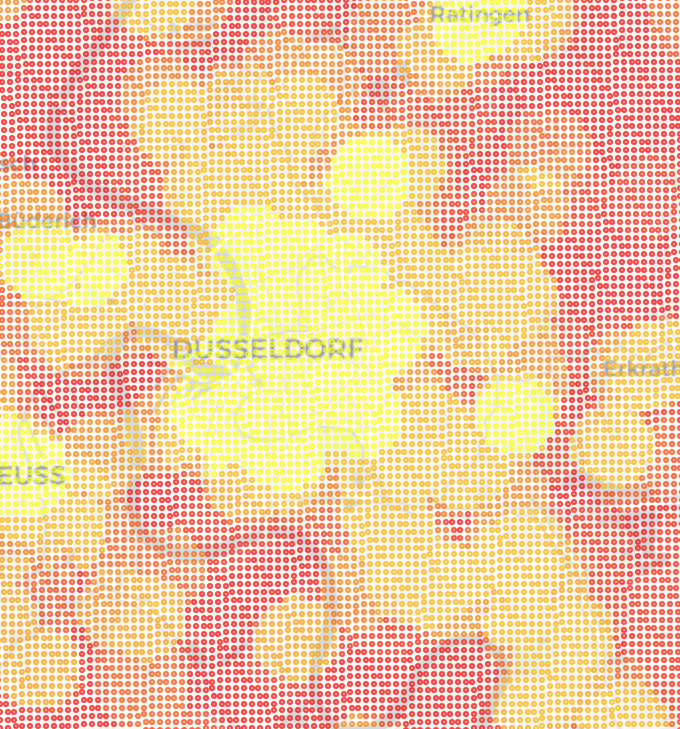

There are several aspects where one could optimize:
- The handling for different keys could be highly optimated. There are loops and definitions of the OSM keys we have brought in, for example, where a more general definition or a more modulized approach would be better.
- Geographical data always turns out being big data. When slightly complex algorithms that have not been optimized come into play, it could turn even worse. This is always an aspect where algorithms could be parallelized, or even more clever concepts are needed. Probably a new story on medium.com has to be written to explain these.

As an outlook one could inorporate different other sources, include prices, routing algorithms or graph theory to visualize even more individual use-cases or tasks.

If you like what you have read, give it a clap. If you want to stay in touch, visit my LinkedIn profile.